# SDE - Lévy processes


## Contents
   - [Merton process](#sec1)
      - [Merton Density](#sec1.1)
      - [Parameter estimation](#sec1.2)
   - [Variance Gamma process](#sec2)
      - [VG Density](#sec2.1)
      - [Parameter estimation](#sec2.2)
   - [Normal Inverse Gaussian process](#sec3)
      - [NIG Density](#sec3.1)
      - [Parameter estimation](#sec3.2)

In [1]:
import numpy as np
import scipy as scp
import scipy.stats as ss
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import scipy.special as scps
from functools import partial
from scipy.optimize import minimize
from math import factorial

import All_functions_for_risk
%run 'All_functions_for_risk.py'


/Users/rutzzz/Risk Management/All_functions_for_risk.py:34: DeprecationWarning: Please use `LinAlgError` from the `scipy.linalg` namespace, the `scipy.linalg.misc` namespace is deprecated.
  from scipy.linalg.misc import LinAlgError


<a id='sec1'></a>
# Merton Jump-Diffusion process

The Merton process is described by the following equation:

\begin{equation}
X_t = \mu t + \sigma W_t + \sum_{i=1}^{N_t} Y_i, 
\end{equation}

where $N_t \sim Po(\lambda t)$ is a Poisson random variable counting the jumps of $X_t$ in $[0,t]$, and 

$$Y_i \sim \mathcal{N}(\alpha, \xi^2)$$ 

are the sizes of the jumps.     
In the following I indicate $\mu \to$ `mu`, $\sigma \to $ `sig`, $\lambda \to $ `lam`, $\alpha \to $ `muJ` and $\xi \to $ `sigJ`.


In [2]:
mu = 0.05  # drift
sig = 0.2  # diffusion coefficient
lam = 1.2  # jump activity
muJ = 0.15  # jump mean size
sigJ = 0.5  # jump std deviation
T = 2  # terminal time
N = 1000000  # number of random variables

<a id='sec1.1'></a>
## Merton Density

##### Simulation

In [3]:
np.random.seed(seed=42)
W = ss.norm.rvs(0, 1, N)  # The normal RV vector
P = ss.poisson.rvs(lam * T, size=N)  # Poisson random vector
Jumps = np.asarray([ss.norm.rvs(muJ, sigJ, i).sum() for i in P])  # Jumps vector
X_T = mu * T + np.sqrt(T) * sig * W + Jumps  # Merton process

##### Merton distribution


In [4]:
def Merton_density(x, T, mu, sig, lam, muJ, sigJ):
    tot = 0
    for k in range(20):
        tot += (
            (lam * T) ** k
            * np.exp(-((x - mu * T - k * muJ) ** 2) / (2 * (T * sig**2 + k * sigJ**2)))
            / (factorial(k) * np.sqrt(2 * np.pi * (sig**2 * T + k * sigJ**2)))
        )
    return np.exp(-lam * T) * tot

##### Merton characteristic function

In [5]:
cf_M_b = partial(cf_mert, t=T, mu=mu, sig=sig, lam=lam, muJ=muJ, sigJ=sigJ)

##### Plot

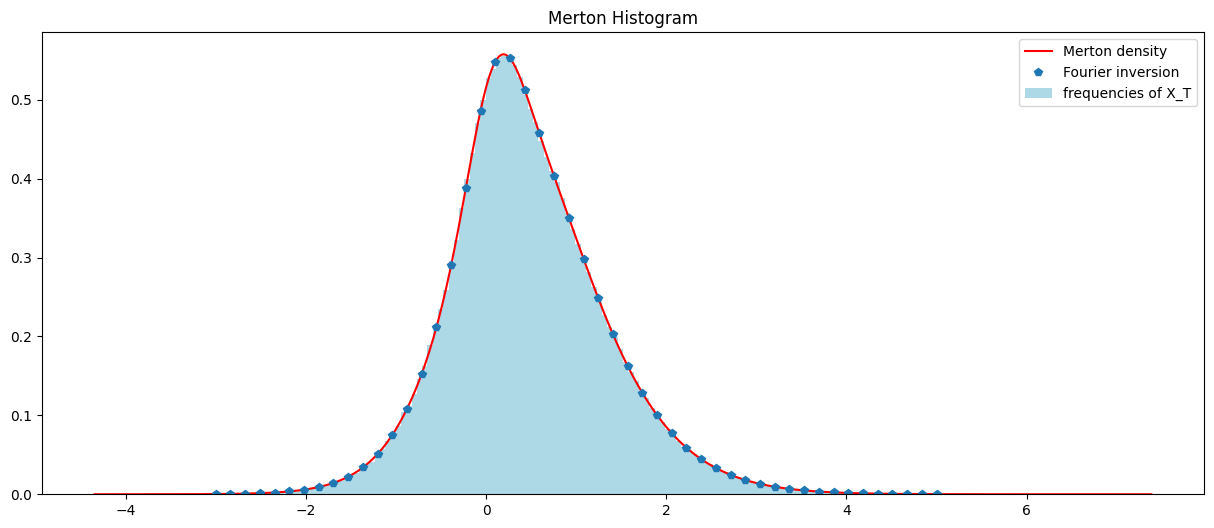

In [6]:
x = np.linspace(X_T.min(), X_T.max(), 500)
y = np.linspace(-3, 5, 50)

plt.figure(figsize=(15, 6))
plt.plot(x, Merton_density(x, T, mu, sig, lam, muJ, sigJ), color="r", label="Merton density")
plt.plot(y, [Gil_Pelaez_pdf(i, cf_M_b, np.inf) for i in y], "p", label="Fourier inversion")
plt.hist(X_T, density=True, bins=200, facecolor="LightBlue", label="frequencies of X_T")
plt.legend()
plt.title("Merton Histogram")
plt.show()

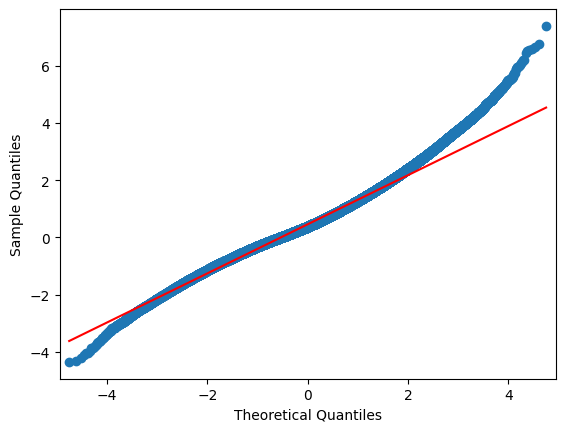

In [7]:
qqplot(X_T, line="s")
plt.show()

<a id='sec1.2'></a>
## Parameter Estimation

In this section, we will employ the `scipy.optimize.minimize` function to minimize the negative of the log-likelihood function. In other words, our goal is to **maximize** the log-likelihood.

It's important to note that the log-likelihood function may have multiple local maxima, or we might encounter overflows during the optimization process.

To address these challenges, we will experiment with various optimization methods to identify the one that yields the best performance.

First, let's take a closer look at our simulated data:


In [8]:
print(f"Median: {np.median(X_T)}")
print(f"Mean: {np.mean(X_T)}")
print(f"Standard Deviation: {np.std(X_T)}")
print(f"Skewness: {ss.skew(X_T)}")
print(f"Kurtosis: {ss.kurtosis(X_T)}")

Median: 0.3785193938994045
Mean: 0.4597291804315835
Standard Deviation: 0.857134840167505
Skewness: 0.44466395968028455
Kurtosis: 1.0056718465894807


##### Maximum Likelihood Estimation

Initial guesses are important! 

- The mean of a Merton process is $\mathbb{E}[X_T] = (\mu + \lambda \alpha) T$. 

In [9]:
print(np.mean(X_T) / T)
print(mu + lam * muJ)

0.22986459021579175
0.22999999999999998


- therefore we can assume equal contribution from `mu` and `lam * muJ`. So, `mu`=0.1.  Of course this is just an initial guess.

- Diffusion coefficient of 0.5 is quite reasonable. A standard deviation of about 0.85 computed above contains also the effects of jumps.

- We don't have information on lambda, so we choose $\lambda=1$ in order to keep the formula for the mean consistent. 

- The histogram has positive skew. The parameter $\alpha$ (or `muJ`) affects the skewness. The value 0.1 makes sense.

- About `sigJ` I set it to $1$, because I expect that a jump has a standard deviation higher than the usual diffusion standard deviation.

In [10]:
def log_likely_Merton(x, data, T):
    return (-1) * np.sum(np.log(Merton_density(data, T, x[0], x[1], x[2], x[3], x[4])))


result_Mert = minimize(
    log_likely_Merton, x0=[0.1, 0.5, 1, 0.1, 1], method="BFGS", args=(X_T, T)
)  # Try also Nelder-Mead

print(result_Mert.message)
print("Number of iterations performed by the optimizer: ", result_Mert.nit)

Desired error not necessarily achieved due to precision loss.
Number of iterations performed by the optimizer:  33


In [11]:
print(f"Original parameters: mu={mu}, sigma={sig}, lam={lam}, alpha={muJ}, xi={sigJ} ")
print("MLE parameters: ", result_Mert.x)

Original parameters: mu=0.05, sigma=0.2, lam=1.2, alpha=0.15, xi=0.5 
MLE parameters:  [0.04779067 0.19977206 1.2072292  0.15081966 0.49841874]



The BFGS and Nelder-Mead methods work! The results are printed in the last line, and we can see that the values correspond to the original values.

I tried also L-BFGS-B and SLSQP which instead do not work.


<a id='sec2'></a>
# Variance Gamma process


Usually the [Gamma distribution] is 
parametrized by a shape and scale positive parameters 

$$T \sim \Gamma(a,b).$$ 

The random variable $T_t \sim \Gamma(a t, b)$ has the shape parameter dependent on $t$ (the shape is a linear function of $t$).    
The density function is 

$$ f_{T_t}(x) = \frac{b^{-a t}}{\Gamma(a t)}x^{a t -1}e^{-\frac{x}{b}}$$ 

with 

$$\mathbb{E}[T_t]= a b t, \quad \text{and} \quad \text{Var}[T_t] = a b^2 t. $$ 

When working with the VG process, it is common to use a parametrization such that 

$$\mathbb{E}[T_t]=\mu t \quad \text{and} \quad \text{Var}[T_t] = \kappa t $$ 

therefore $\mu = ab$ and $\kappa = a b^2$.
Inverting we obtain $b=\frac{\kappa}{\mu}$, $a=\frac{\mu^2}{\kappa}$.

The new parametrization is with respect to the new parameters $\mu$ and $\kappa$, such that  

$$T_t \sim \Gamma(\mu t, \kappa t)$$

#### Variance Gamma

If we consider a Brownian motion with drift 

$$X_t = \theta t + \sigma W_t$$ 

and substitute the time variable with a Gamma random variable 
$T_t \sim \Gamma(t,\kappa t)$,
we obtain the **Variance Gamma** process:

$$ X_{t} := \theta T_t + \sigma W_{T_t} .$$

where we chose $T_t \sim \Gamma(\mu t, \kappa t)$ with $\mu=1$ in order to have $\mathbb{E}[T_t]= t$.

It depends on three parameters:

- $\sigma$, the volatility of the Brownian motion
- $\kappa$, the variance of the Gamma process
- $\theta$, the drift of the Brownian motion

The characteristic function is: 

$$ \phi_{X_t}(u) = \biggl( 1-i\theta \kappa u + \frac{1}{2} \sigma^2 \kappa u^2 \biggr)^{-\frac{t}{\kappa}}.$$

The first four moments are: 

$$
\begin{aligned}
 \mathbb{E}[X_t] &= t\theta. \\ \nonumber
 \text{Var}[X_t] &= t(\sigma^2 + \theta^2 \kappa). \\ \nonumber
 \text{Skew}[X_t] &= \frac{t (2\theta^3\kappa^2 + 3 \sigma^2 \theta \kappa)}{\bigl(\text{Var}[X_t])^{3/2}}. \\ \nonumber
 \text{Kurt}[X_t] &= \frac{t (3\sigma^4 \kappa + 12\sigma^2 \theta^2 \kappa^2 +6\theta^4\kappa^3)}{\bigl(\text{Var}[X_t]\bigr)^2}.\nonumber 
\end{aligned} 
$$




<a id='sec2.1'></a>
## VG Density



##### Simulation

In [12]:
T = 2  # terminal time
N = 1000000  # number of generated random variables

theta = -0.1  # drift of the Brownian motion
sigma = 0.2  # volatility of the Brownian motion
kappa = 0.5  # variance of the Gamma process

In [13]:
np.random.seed(seed=42)
G = ss.gamma(T / kappa, scale=kappa).rvs(N)  # The gamma RV
Norm = ss.norm.rvs(0, 1, N)  # The normal RV
X = theta * G + sigma * np.sqrt(G) * Norm

##### VG Density

In [14]:
def VG_density(x, T, c, theta, sigma, kappa):
    return (
        2
        * np.exp(theta * (x - c) / sigma**2)
        / (kappa ** (T / kappa) * np.sqrt(2 * np.pi) * sigma * scps.gamma(T / kappa))
        * ((x - c) ** 2 / (2 * sigma**2 / kappa + theta**2)) ** (T / (2 * kappa) - 1 / 4)
        * scps.kv(T / kappa - 1 / 2, sigma ** (-2) * np.sqrt((x - c) ** 2 * (2 * sigma**2 / kappa + theta**2)))
    )

##### Fourier inversion of the VG characteristic function

In [15]:
cf_VG_b = partial(cf_VG, t=T, mu=0, theta=theta, sigma=sigma, kappa=kappa)

##### Histogram vs density vs Fourier inversion

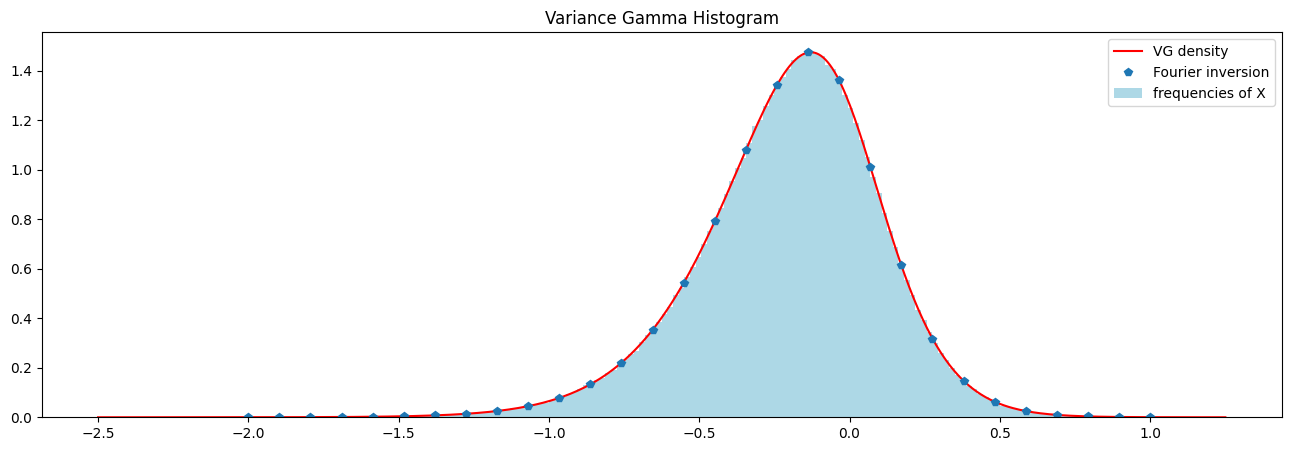

In [16]:
x = np.linspace(X.min(), X.max(), 500)
y = np.linspace(-2, 1, 30)

plt.figure(figsize=(16, 5))
plt.plot(x, VG_density(x, T, 0, theta, sigma, kappa), color="r", label="VG density")
plt.plot(y, [Gil_Pelaez_pdf(i, cf_VG_b, np.inf) for i in y], "p", label="Fourier inversion")
plt.hist(X, density=True, bins=200, facecolor="LightBlue", label="frequencies of X")
plt.legend()
plt.title("Variance Gamma Histogram")
plt.show()

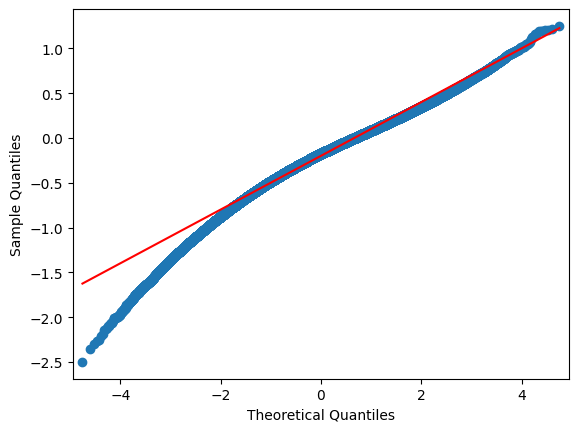

In [17]:
qqplot(X, line="s")
plt.show()

<a id='sec2.2'></a>
## Parameter Estimation

Let us consider a VG process with an additional (deterministic) drift \(c\):

$$ Y_t = c t + X^{VG}_t $$

such that \(\mathbb{E}[Y_t] = t (\theta + c)\).

This is a more general setting that keeps into account a possible "location" parameter for the VG distribution (the function `VG_density` already considers the location parameter \(c\)).

The formulas for higher order moments are unchanged.    
The characteristic function if \(Y_t\) is:

$$ \phi_{Y_t}(u) = e^{icu} \left( 1-i\theta \kappa u + \frac{1}{2} \sigma^2 \kappa u^2 \right)^{-\frac{t}{\kappa}}.$$


### Approximated Method of Moments

This method suggests to consider only the first order terms in $\theta$ and ignore $\theta^2$, $\theta^3$ and $\theta^4$.      
This method is motivated by the fact that usually $\theta$ is quite small.

Since there are 4 parameters to estimate, we need 4 equations i.e. the formulas for the first 4 moments.     
We get:

$$ \begin{aligned}
 \mathbb{E}[X_t] &= t \, (c+\theta). \\
 \text{Var}[X_t] &= t \, \sigma^2. \\ 
 \text{Skew}[X_t] &= \frac{1}{\sqrt{t}} \frac{3 \theta \kappa}{\sigma}. \\
 \text{Kurt}[X_t] &= \frac{1}{t} 3\kappa 
\end{aligned} $$

Inverting we have:

$$ \begin{aligned}
 \kappa &= \frac{t \text{Kurt}[X_t]}{3} \\ 
 \sigma &= \frac{\text{Std}[X_t]}{\sqrt{t}}. \\ 
 \theta &= \frac{\sqrt{t} \text{Skew}[X_t] \sigma}{3 \kappa}. \\
  c &= \frac{\mathbb{E}[X_t]}{t} - \theta. \\
\end{aligned} $$

From the formulas above we obtained interesting information:
- The parameter $\theta$ is connected with the **skewness**. (The sign of $\theta$ indicates if the distribution has positive or negative skewness)
- The parameter $\kappa$ represents the amount of **kurtosis** of the distribution. 

In [18]:
sigma_mm1 = np.std(X) / np.sqrt(T)
kappa_mm1 = T * ss.kurtosis(X) / 3
theta_mm1 = np.sqrt(T) * ss.skew(X) * sigma_mm1 / (3 * kappa_mm1)
c_mm1 = np.mean(X) / T - theta_mm1

print(
    "Estimated parameters: \n\n c={} \n theta={} \n sigma={} \n \
kappa={}\n".format(
        c_mm1, theta_mm1, sigma_mm1, kappa_mm1
    )
)
print("Estimated c + theta = ", c_mm1 + theta_mm1)

Estimated parameters: 

 c=-0.018543777252323673 
 theta=-0.08144922792709254 
 sigma=0.21200595513004386 
 kappa=0.5904713302435356

Estimated c + theta =  -0.09999300517941621


The approximated method gives very good results!! 

Only two remarks:     
- We simulated the process with $c=0$ and $\theta=-0.1$. Therefore, only the parameter $\theta$ contributes to the mean of the distribution. The results of this estimation process, assign a little part of the true value of $\theta$ to $c$, which instead should be zero.
- The estimated value of the parameter $\kappa$ is not very precise.


### MLE

An alternative method to estimate the parameters is to use the Maximum Likelihood Estimator.

In the following cell I use the function `scipy.optimize.minimize` to minimize the negative of the log-likelihood, i.e. I maximize the log-likelihood.

Since there are 4 parameters to be estimated, the routine can be very slow.    
Fortunately there are some tricks we can use in order to speed up the task.

1) We can use the values estimated with the *approximated method of moments* as **initial guesses**. It is reasonable to expect that they are quite good initial guesses.

2) Look at the **Histogram** above. From the histogram we can extract some information:
   - The range for the mean $c$ i.e. $[-1,1]$ 
   - The skewness is negative, therefore $\theta$ must be negative. I chose the interval $[-1,-10^{-15}]$.
   - For $\sigma$ and $\kappa$ I chose the reasonable intervals $[10^{-15},2]$ and $[10^{-15},\infty)$.  

Using a method with constraints such as 'L-BFGS-B' is helpful to reduce the computational time. 


In [19]:
%%time


def log_likely(x, data, T):
    return (-1) * np.sum(np.log(VG_density(data, T, x[0], x[1], x[2], x[3])))


result_VG = minimize(
    log_likely,
    x0=[c_mm1, theta_mm1, sigma_mm1, kappa_mm1],
    method="L-BFGS-B",
    args=(X, T),
    tol=1e-8,
    bounds=[[-1, 1], [-1, -1e-15], [1e-15, 2], [1e-15, None]],
)

print(result_VG.message)
print("Number of iterations performed by the optimizer: ", result_VG.nit)
print("MLE parameters: ", result_VG.x)

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Number of iterations performed by the optimizer:  18
MLE parameters:  [ 0.00442142 -0.10220379  0.19960388  0.48852081]
CPU times: user 51.1 s, sys: 23.2 ms, total: 51.1 s
Wall time: 51.4 s


<a id='sec3'></a>
## NIG process


##### Inverse Gaussian (IG) distribution

Usually, the [IG distribution] is parametrized by two parameters: the mean ($\mu$) and the shape ($\lambda$):

$$ T \sim IG(\mu, \lambda) $$

where

$$ f_{T}(x) = \sqrt{\frac{\lambda}{2\pi x^3}} e^{- \frac{\lambda(x-\mu)^2}{2\mu^2 x} } $$ 

with 

$$\mathbb{E}[T]= \mu, \quad \text{and} \quad \text{Var}[T] = \frac{\mu^3}{\lambda}. $$ 

The python function [scipy.stats.invgauss]is implemented for $\lambda=1$.    
To generate a distribution with a different $\lambda$, we have to scale both the variable $x$ and the mean $\mu$:

$$ x \to \frac{x}{\lambda} \quad \mu \to \frac{\mu}{\lambda} $$

The **IG distribution** is the distribution of the first passage time of a Brownian motion with drift $\gamma \geq 0$, for a barrier $\delta>0$. 

If we let the barrier to be a linear function of the time $t$, we obtain the IG process. 

##### IG process

The IG process $T_t$ can be defined as:

$$ dZ_t = \gamma dt + dW_t $$

$$ T_t = \inf \bigl\{ s>0 : Z_s = \delta t \bigr\} $$

where $\{Z_s : s\geq 0\}$ is a Brownian motion with drift $\gamma \geq 0$ and unitary diffusion coefficient.   
The IG process at time $t$ is distributed as 
 
$$ T_t \sim IG \biggl( \frac{\delta t }{\gamma}, \delta^2 t^2 \biggr).$$

It is useful to consider the parameterization in terms of mean ($\mu$) and variance ($\kappa$).    
The variance is $\text{Var}[T] = \frac{\mu^3}{\lambda}$. By changing variables we get $\text{Var}[T_t] = \frac{\delta t}{\gamma^3}$. Let us call $$\kappa = \frac{\delta}{\gamma^3}.$$



In [20]:
np.random.seed(seed=42)
paths = 40000  # number of paths
steps = 10000  # number of time steps

t = 2
delta = 3 * t  # time dependent barrier
gamma = 2  # drift
T_max = 20
T_vec, dt = np.linspace(0, T_max, steps, retstep=True)
X0 = np.zeros((paths, 1))  # each path starts at zero
increments = ss.norm.rvs(loc=gamma * dt, scale=np.sqrt(dt), size=(paths, steps - 1))

Z = np.concatenate((X0, increments), axis=1).cumsum(1)
T = np.argmax(Z > delta, axis=1) * dt  # first passage time

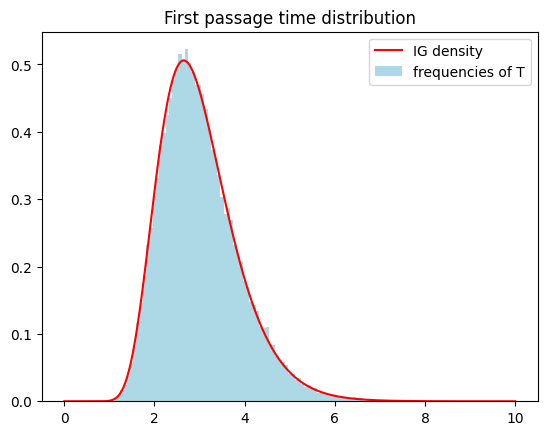

Theoretical mean:  3.0
Theoretical variance:  0.75
Estimated mean:  3.017242724272428
Estimated variance:  0.7578786228647868


In [21]:
x = np.linspace(0, 10, 10000)
mm = delta / gamma
lam = delta**2
mm1 = mm / lam  # scaled mean

plt.plot(x, ss.invgauss.pdf(x, mu=mm1, scale=lam), color="red", label="IG density")
plt.hist(T, density=True, bins=100, facecolor="LightBlue", label="frequencies of T")
plt.title("First passage time distribution")
plt.legend()
plt.show()

print("Theoretical mean: ", mm)
print("Theoretical variance: ", delta / gamma**3)
print("Estimated mean: ", T.mean())
print("Estimated variance: ", T.var())

#### Normal Inverse Gaussian (NIG)

Following the same argument used to build the Variance Gamma process, we consider a Brownian motion with drift 

$$ X_t = \theta t + \sigma W_t$$ 

and substitute the time variable with an Inverse Gaussian random variable 
$T_t \sim \Gamma(t,\kappa t)$,
we obtain the **Normal Inverse Gaussian** process:

$$
 X_{t} := \theta T_t + \sigma W_{T_t} .
$$

where we chose 

$$T_t \sim IG\biggl( \mu=t, \lambda= \frac{t^2}{\kappa} \biggr),$$ 

with $\delta=\gamma$ and $\kappa = 1/\gamma^2$ in order to have $\mathbb{E}[T_t]= t$.

The NIG process depends on three parameters:

- $\sigma$, the volatility of the Brownian motion
- $\kappa$, the variance of the IG process
- $\theta$, the drift of the Brownian motion

The characteristic function is: 

$$ \phi_{X_t}(u) = \frac{1}{\kappa} \biggl( 1 - \sqrt{1 - i2 \theta \kappa u + \sigma^2 \kappa u^2} \biggr) .$$

The first four moments are: 

$$ \begin{aligned}
 \mathbb{E}[X_t] &= t\theta. \\
 \text{Var}[X_t] &= t(\sigma^2 + \theta^2 \kappa). \\
 \text{Skew}[X_t] &= \frac{t (3\theta^3\kappa^2 + 3 \sigma^2 \theta \kappa)}{\bigl(\text{Var}[X_t])^{3/2}}. \\ 
 \text{Kurt}[X_t] &= \frac{t (3\sigma^4 \kappa + 18\sigma^2 \theta^2 \kappa^2 +15\theta^4\kappa^3)}{\bigl(\text{Var}[X_t]\bigr)^2}. 
\end{aligned} $$


<a id='sec3.1'></a>
## NIG Density


##### Simulation

In [22]:
T = 2  # terminal time
N = 1000000  # number of generated random variables

theta = -0.1  # drift of the Brownian motion
sigma = 0.2  # volatility of the Brownian motion
kappa = 0.5  # variance of the Gamma process

lam = T**2 / kappa  # scale
mus = T / lam  # scaled mu

In [23]:
np.random.seed(seed=42)
IG = ss.invgauss.rvs(mu=mus, scale=lam, size=N)  # The IG RV
Norm = ss.norm.rvs(0, 1, N)  # The normal RV
X = theta * IG + sigma * np.sqrt(IG) * Norm

##### NIG Density

In [24]:
def NIG_density(x, T, c, theta, sigma, kappa):
    A = theta / (sigma**2)
    B = np.sqrt(theta**2 + sigma**2 / kappa) / sigma**2
    C = T / np.pi * np.exp(T / kappa) * np.sqrt(theta**2 / (kappa * sigma**2) + 1 / kappa**2)
    return (
        C
        * np.exp(A * (x - c * T))
        * scps.kv(1, B * np.sqrt((x - c * T) ** 2 + T**2 * sigma**2 / kappa))
        / np.sqrt((x - c * T) ** 2 + T**2 * sigma**2 / kappa)
    )

The NIG density usually is indicated with the parameters:
$$ \beta = \frac{\theta}{\sigma^2}, \quad \quad \alpha = \sqrt{ \beta^2 + \frac{1}{\kappa \sigma^2} } $$
$$ \delta = \frac{T \sigma}{\sqrt{\kappa}}, \quad \quad  \mu = c T $$

See [3] for instance. However, I prefer to use the ($\theta,\sigma,\kappa$) parameters, as in [1].

The following function corresponds to the NIG($\alpha, \beta, \delta, \mu$) density:

In [25]:
def NIG_abdmu(x, T, c, theta, sigma, kappa):
    beta = theta / (sigma**2)
    alpha = np.sqrt(beta**2 + 1 / (kappa * sigma**2))
    delta = T * sigma / np.sqrt(kappa)
    mu = c * T
    g = lambda y: np.sqrt(delta**2 + (x - mu) ** 2)
    cost = delta * alpha / np.pi
    return (
        cost
        * np.exp(delta * np.sqrt(alpha**2 - beta**2) + beta * (x - mu))
        * scps.kv(1, alpha * g(x - mu))
        / g(x - mu)
    )

##### Fourier inversion of the NIG characteristic function

In [26]:
cf_NIG_b = partial(cf_NIG, t=T, mu=0, theta=theta, sigma=sigma, kappa=kappa)

##### Histogram vs density vs Fourier inversion

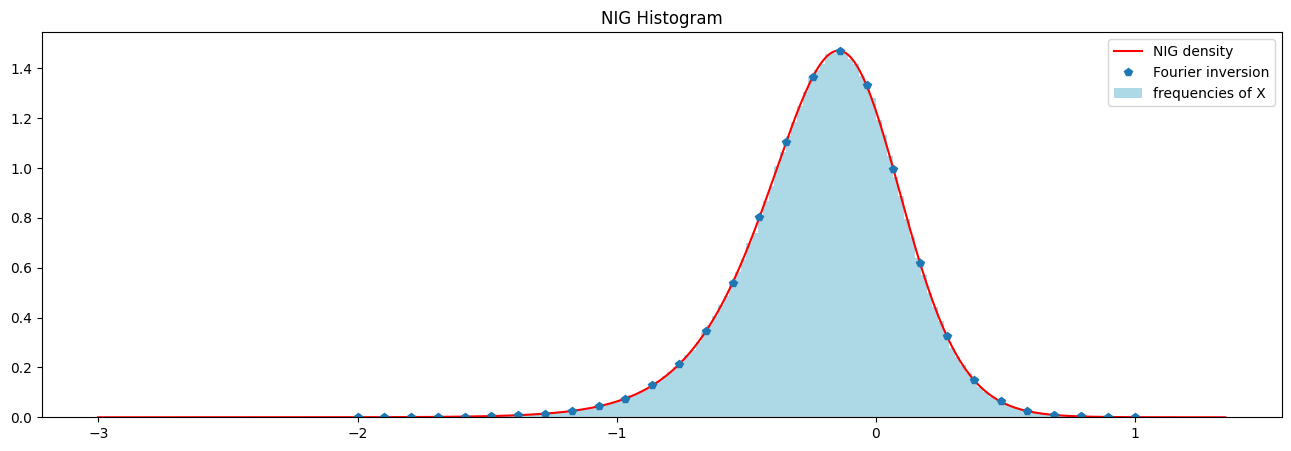

In [27]:
x = np.linspace(X.min(), X.max(), 500)
y = np.linspace(-2, 1, 30)

plt.figure(figsize=(16, 5))
plt.plot(x, NIG_density(x, T, 0, theta, sigma, kappa), color="r", label="NIG density")
plt.plot(y, [Gil_Pelaez_pdf(i, cf_NIG_b, np.inf) for i in y], "p", label="Fourier inversion")
plt.hist(X, density=True, bins=200, facecolor="LightBlue", label="frequencies of X")
plt.legend()
plt.title("NIG Histogram")
plt.show()

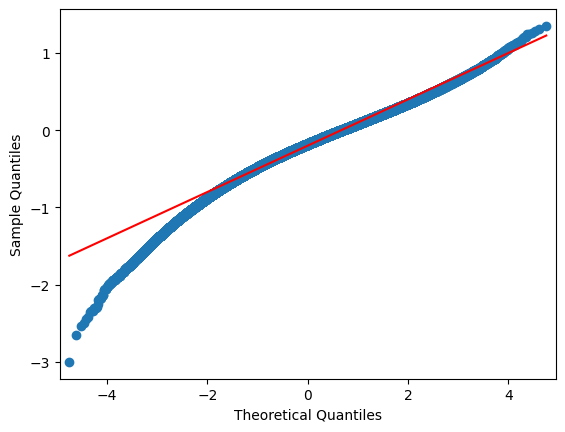

In [28]:
qqplot(X, line="s")
plt.show()

<a id='sec3.2'></a>
## Parameter estimation

Since the moments at first order in $\theta$ are the same as in the VG process, we can use the same technique to get an approximated estimate of the parameters.

After that we can use those approximated values as initial guess for the MLE estimation.

In [29]:
sigma_mm1 = np.std(X) / np.sqrt(T)
kappa_mm1 = T * ss.kurtosis(X) / 3
theta_mm1 = np.sqrt(T) * ss.skew(X) * sigma_mm1 / (3 * kappa_mm1)
c_mm1 = np.mean(X) / T - theta_mm1

print(
    "Estimated parameters: \n\n c={} \n theta={} \n sigma={} \n \
kappa={}\n".format(
        c_mm1, theta_mm1, sigma_mm1, kappa_mm1
    )
)
print("Estimated c + theta = ", c_mm1 + theta_mm1)

Estimated parameters: 

 c=-0.029490461790484923 
 theta=-0.0703900720616428 
 sigma=0.21211113318032002 
 kappa=0.708309868095375

Estimated c + theta =  -0.09988053385212772


In [30]:
%%time


def log_likely_NIG(x, data, T):
    return (-1) * np.sum(np.log(NIG_density(data, T, x[0], x[1], x[2], x[3])))


result_NIG = minimize(
    log_likely_NIG,
    x0=[c_mm1, theta_mm1, sigma_mm1, kappa_mm1],
    method="L-BFGS-B",
    args=(X, T),
    tol=1e-8,
    bounds=[[-1, 1], [-1, -1e-15], [1e-15, 2], [1e-15, None]],
)

print(result_NIG.message)
print("Number of iterations performed by the optimizer: ", result_NIG.nit)
print("MLE parameters: ", result_NIG.x)

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Number of iterations performed by the optimizer:  19
MLE parameters:  [ 0.00104242 -0.10092294  0.19980888  0.49901722]
CPU times: user 46.7 s, sys: 21.8 ms, total: 46.7 s
Wall time: 46.9 s


## References

[1] Rama Cont and Peter Tankov (2003) "Financial Modelling with Jump Processes", Chapman and Hall/CRC; 1 edition.  

[2] Madan D. and Seneta E. (1990) "The Variance Gamma model for share market returns". The journal of Business. 63(4), 511-524 

[3] Barndorff-Nielsen, Ole E. (1998) "Processes of Normal Inverse Gaussian type" Finance and Stochastics 2, 41-68.